# 稀疏矩阵
---

数组和矩阵是数值计算的基础元素。目前为止，我们都是使用NumPy的ndarray数据结构来表示数组，这是一种同构的容器，用于存储数组的所有元素。

有一种特殊情况，矩阵的大部分元素都为零，这种矩阵被称为稀疏矩阵。对于稀疏矩阵，将所有零保存在计算机内存中的效率很低，更合适的方法是只保存非零元素以及位置信息。

假设存在一个神经网络，16个神经元分布在一个4×4的二维矩形网格上，其中只有最近邻的神经元是相连的。那么，神经网络的连接情况就可以表示为一个稀疏矩阵。

<img src="Images/Sparse_Matrix.png" style="width: 400px;"/>

## 导入模块
---

SciPy中提供了稀疏矩阵模块`scipy.sparsse`，为稀疏矩阵的表示及其线性代数运算提供了丰富易用的接口。

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

import scipy.sparse as sp
import scipy.sparse.linalg

import scipy.linalg as la

## SciPy中的稀疏矩阵
---
下方表格总结和比较了了SciPy的sparse模块中可用的稀疏矩阵表示法。

| 类型 | Python类 | 描述 | 优点 | 缺点 |
|---|---|---|---|---|
| 坐标的列表 |[sp.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)| 将非零值及其行列信息保存在一个列表 | 构造简单，添加元素方便 | 访问元素效率低下 |
| 列表的列表 |[sp.lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)| 将每行的非零元素列索引保存在一个列表，将对应值保存在另一个列表 | 支持切片操作 | 不方便进行数学运算 |
| 值的字典 |[sp.dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html)| 将非零值保存在字典，非零值的坐标元组作为字典的键 | 构造简单，可快速添加删除元素 | 不方便进行数学运算 |
| 对角矩阵 |[sp.dia_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html)| 矩阵的对角线列表 | 对于对角矩阵非常有效 | 不适用非对角矩阵 |
| 压缩列格式和压缩行格式 |[sp.csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) 和 [sp.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) | 将值与行列索引的数组一起存储 | 对于矩阵的向量乘法很高效 | 构造相对复杂 |
| 块稀疏矩阵 |[sp.bsr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html)| 与CSR类似，用于具有稠密子矩阵的稀疏矩阵 | 对于此类特殊矩阵很高效 | 不适用一般矩阵 |

### 坐标列表格式 COO

例如，我们在SciPy对下面稀疏矩阵以COO格式进行初始化：

$$
A = 
\begin{bmatrix}0 \ 1 \ 0 \ 0 \\
0 \ 0 \ 0 \ 2 \\
0 \ 0 \ 3 \ 0 \\
4 \ 0 \ 0 \ 0 \end{bmatrix}
$$

为了创建`sp.coo_matrix`对象，我们需要创建非零值、行索引以及列索引的列表或数组，并将其传递给生成函数`sp.coo_matrix`。

In [2]:
values = [1, 2, 3, 4]
rows = [0, 1, 2, 3]
cols = [1, 3, 2, 0]
A = sp.coo_matrix((values, (rows, cols)), shape=[4, 4])
A

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in COOrdinate format>

SciPy的sparse模块中稀疏矩阵的属性大部分派生自NumPy的ndarray对象，同时也包括nnz（非零元素数目）和data（非零值）等属性。

In [3]:
A.shape, A.size, A.dtype, A.ndim

((4, 4), 4, dtype('int64'), 2)

In [4]:
A.nnz, A.data

(4, array([1, 2, 3, 4]))

对于`sp.coo_matrix`对象，我们还可以使用row和col属性来访问底层的行列坐标数组。

In [5]:
A.row, A.col

(array([0, 1, 2, 3], dtype=int32), array([1, 3, 2, 0], dtype=int32))

### 格式转换

稠密矩阵和稀疏矩阵，以及不同格式稀疏矩阵之间，可以很方便地进行格式转换。

In [6]:
A.todense()  # 转换为稠密矩阵

matrix([[0, 1, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 3, 0],
        [4, 0, 0, 0]])

In [7]:
A.toarray()  # 转换为ndarray数组

array([[0, 1, 0, 0],
       [0, 0, 0, 2],
       [0, 0, 3, 0],
       [4, 0, 0, 0]])

In [8]:
A.tocsr()  # 转换为CSR格式

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

主要注意，不是所有的格式支持索引。

In [9]:
try:
    A.tobsr()[1]  # 块稀疏矩阵不支持索引
except NotImplementedError:
    print("NotImplementedError")

NotImplementedError


### 压缩列格式和压缩行格式 CSR/CSC

对于数值计算而言，SciPy的sparse模块中最重要的稀疏矩阵表示是CSR和CSC格式，因为它们非常适合进行有效的矩阵运算和线性代数运算。在准备好需要计算的稀疏矩阵后，可以使用`toscr`或者`tocsc`将其转换为CSR格式或者CSC格式。

In [10]:
A = np.array([[1, 2, 0, 0], [0, 3, 4, 0], [0, 0, 5, 6], [7, 0, 8, 9]])
A

array([[1, 2, 0, 0],
       [0, 3, 4, 0],
       [0, 0, 5, 6],
       [7, 0, 8, 9]])

In [11]:
A = sp.csr_matrix(A)
A.data  # 所有非零元素

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
A.indices # 非零元素列序号

array([0, 1, 1, 2, 2, 3, 0, 2, 3], dtype=int32)

In [13]:
A.indptr  # 每一行第一个非零元素在data中的起始序号

array([0, 2, 4, 6, 9], dtype=int32)

![](Images/CSR.png)

## 创建稀疏矩阵
---

一种创建稀疏矩阵的方法是对普通矩阵进行格式转换。同时，`sp.sparse`模块提供了很多用于生成此类矩阵的函数。

`sp.eye`用于生成对焦矩阵，`sp.kron`用于计算两个稀疏矩阵的Kronecker张量积，`bmat`、`vstack`和`hstack`用于从稀疏块矩阵、垂直和水平堆叠矩阵来生成稀疏矩阵。

例如，我们重复调用`sp.eye`生成一个具有多个对角线的矩阵，其中使用了k参数设置相对主对角线的偏移量。

In [14]:
N = 10
A = -2 * sp.eye(N) + sp.eye(N, k=1) + sp.eye(N, k=-1)
print(type(A))
A.todense()

<class 'scipy.sparse.csr.csr_matrix'>


matrix([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

默认情况下，得到的是CSR格式的稀疏矩阵。使用format参数，可以指定任意其它稀疏矩阵格式。

In [15]:
A = sp.diags([1,-2,1], [1,0,-1], shape=[N, N], format='csc')
A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Column format>

可以注意到，这个矩阵是离散空间下二阶微分操作（[拉普拉斯算子](https://zh.wikipedia.org/wiki/拉普拉斯算子)）的矩阵表示。

$$\frac{d^{2} f}{d x^{2}}=\lim _{h \rightarrow 0} \frac{f(x-h)-2 f(x)+f(x+h)}{h^{2}}$$  

$$
\frac{d^{2} f}{d x^{2}}=\begin{bmatrix}\begin{array}{ccccccc}-2 & 1 & 0  & \ldots & 0 & 0 \\ 1 & -2 & 1 & \ldots & 0 & 0 \\ 0 & 1 & -2 & \ldots & 0 & 0 \\ \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\ 0 & 0 & 0 & \ldots & -2 & 1 \\ 0 & 0 & 0 & \ldots & 1 & -2\end{array}\end{bmatrix}\begin{bmatrix}\begin{array}{c}f(a) \\ f(a+h) \\ f(a+2 h) \\ \ldots \\ f(a+(n-2) h) \\ f(b)\end{array}\end{bmatrix} / h^{2}=\operatorname{Lap}|f\rangle
$$  

### 稀疏矩阵的可视化

matplotlib提供的`spy`函数可以对稀疏矩阵进行可视化。

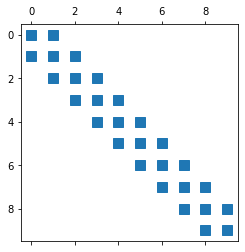

In [16]:
fig, ax = plt.subplots()
ax.spy(A)

稀疏矩阵经常和张量积空间相关。使用`sp.kron`函数，可以将多个较小的矩阵组成单个大的稀疏矩阵。

神经网络中的变换都可以简化为数值数据张量上的一些张量计算。

In [17]:
B = sp.diags([1, 1], [-1, 1], shape=[3,3])
B.todense()

matrix([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])

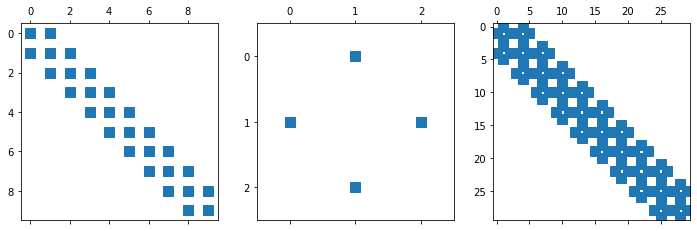

In [18]:
C = sp.kron(A, B, format='csr')

fig, (ax_A, ax_B, ax_C) = plt.subplots(1, 3, figsize=(12, 4))
ax_A.spy(A)
ax_B.spy(B)
ax_C.spy(C)

## 稀疏矩阵线性代数
---

稀疏矩阵的主要应用是在大型矩阵上进行线性代数运算。SciPy的`sparse`模块中包含的`linalg`子模块实现了很多线性代数运算。

稀疏线性代数模块`scipy.sparse.linalg`和稠密线性代数模块`scipy.linalg`的运算行为存在很多差异。例如，用于稠密问题的特征值求解器通常会计算返回所有的特征值和特征向量。对于稀疏矩阵而言，为了保证稀疏性和计算效率，它的特征值求解器通常只返回少量的特征值和特征向量，例如特征值最大或最小的部分。

当然，这种差异性在大部分场景不会影响稀疏线性代数模块的应用。因为很多时候我们只关心最小或者做大的部分特征值。例如求解薛定谔方程时，特征值（能量值）最低的结果是最重要的。

### 线性方程组

我们考虑$Ax=b$形式的线性方程组，以前面提到的三对角矩阵为例：

In [19]:
N = 10
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
b = -np.ones(N)

首先使用SciPy提供的稀疏矩阵求解器：

In [20]:
x = sp.linalg.spsolve(A, b)
x

array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.])

为了对比，我们也使用SciPy提供的稠密矩阵求解器：

In [21]:
B = A.todense()
x = la.solve(B, b)
x

array([ 5.,  9., 12., 14., 15., 15., 14., 12.,  9.,  5.])

为了对比两者的速度差异，我们可以尝试较大的矩阵：

In [22]:
N = 1000
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
b = -np.ones(N)
B = A.todense()

In [23]:
%time x = sp.linalg.spsolve(A, b)

CPU times: user 2.31 ms, sys: 152 µs, total: 2.46 ms
Wall time: 3.47 ms


In [24]:
%time x = la.solve(B, b)

CPU times: user 110 ms, sys: 16.8 ms, total: 127 ms
Wall time: 66 ms


可以看到，当N很大时，稀疏矩阵的运算速度有很大优势。

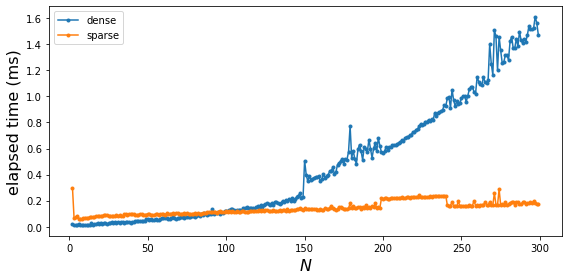

In [25]:
# compare performance of solving Ax=b vs system size N,
# where A is the sparse matrix for the 1d poisson problem

import time

def setup(N):
    A = sp.diags([1,-2,1], [1,0,-1], shape=[N, N], format='csr')
    b = -np.ones(N)
    return A, A.todense(), b

reps = 10
N_vec = np.arange(2, 300, 1)
t_sparse = np.empty(len(N_vec))
t_dense = np.empty(len(N_vec))
for idx, N in enumerate(N_vec):
    A, A_dense, b = setup(N)
    t = time.time()
    for r in range(reps):
        x = np.linalg.solve(A_dense, b)
    t_dense[idx] = (time.time() - t)/reps
    t = time.time()
    for r in range(reps):
        x = sp.linalg.spsolve(A, b, use_umfpack=True)
    t_sparse[idx] = (time.time() - t)/reps
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(N_vec, t_dense * 1e3, '.-', label="dense")
ax.plot(N_vec, t_sparse * 1e3, '.-', label="sparse")
ax.set_xlabel(r"$N$", fontsize=16)
ax.set_ylabel("elapsed time (ms)", fontsize=16)
ax.legend(loc=0)
fig.tight_layout()

### LU分解

一种替代`spsolve`接口的方法时使用`sp.sparse.splu`或`sp.sparse.splu`（不完全LU分解）。如果需要为多组向量$b$求解$Ax=b$，这将特别有用。

In [26]:
N = 1000
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
b = -np.ones(N)

%time lu = sp.linalg.splu(A)

CPU times: user 1.19 ms, sys: 15 µs, total: 1.21 ms
Wall time: 1.13 ms


In [27]:
lu.L, lu.U

(<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2000 stored elements in Compressed Sparse Column format>,
 <1000x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2000 stored elements in Compressed Sparse Column format>)

进行LU分解之后，就可以使用lu对象的solve方法有效求解$Ax=b$了。

In [28]:
x = lu.solve(b)

### 特征值问题

可以分别使用`sp.linalg.eigs`和`sp.linalg.svds`函数来求解稀疏矩阵的特征值和奇异值问题。对于实数对阵矩阵或者复数Hermitian矩阵，也可以使用`sp.linalg.eigsh`函数来计算特征值和特征向量。

这些函数只会计算给定数量的特征值和特征向量（默认为6个）。使用关键词k，可以设置所需计算的特征值的数量。使用关键词which（例如，'LM'为绝对值最大，'SM'为绝对值最大），可以设置计算哪一部分的特征值。

例如，我们计算一维泊松问题（系统尺寸为10×10）中稀疏矩阵的最大模的四个特征值：

In [29]:
N = 10
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')

evals, evecs = sp.linalg.eigs(A, k=4, which='LM')
evals

array([-3.91898595+0.j, -3.68250707+0.j, -3.30972147+0.j, -2.83083003+0.j])

`sp.linalg.eigs`函数返回的是一个元组，其中第一个元素是特征值数组，第二个元素是特征向量数组。

我们期望A和特征向量之间的点积等于对应特征值对特征向量的缩放，下面将验证这一点：

In [30]:
np.allclose(A.dot(evecs[:,0]), evals[0] * evecs[:,0])  # 排除浮点数误差影响

True

我们下面将对比稀疏矩阵和稠密矩阵在计算大矩阵特征值问题上的速度差异：

In [31]:
N = 1000
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
B = A.todense()

In [32]:
%time evals, evecs = sp.linalg.eigs(A, k=4, which='LM')

CPU times: user 1.97 s, sys: 55.2 ms, total: 2.02 s
Wall time: 1.02 s


In [33]:
%time evals, evecs = la.eig(B)

CPU times: user 5.25 s, sys: 116 ms, total: 5.37 s
Wall time: 2.74 s
